In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from rouge_score import rouge_scorer
from nltk.translate.meteor_score import meteor_score
import nltk
import Levenshtein

In [3]:
# make everything bold, comment out if you don't like it
plt.rcParams.update({'font.weight': 'bold', 'axes.labelweight': 'bold', 'axes.titleweight': 'bold'})

# Avoid Type 3 fonts in PDF output
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [4]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /home/ali/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [5]:
ALPHA = 0.5

In [6]:
def calculate_levenshtein_accuracy(true_sentence, generated_sentence):
    distance = Levenshtein.distance(true_sentence, generated_sentence)
    max_len = max(len(true_sentence), len(generated_sentence))
    return 1 - (distance / max_len)

def calculate_bleu_score(true_sentence, generated_sentence):
    # Use a smoothing function to avoid BLEU score being zero
    smoothing_function = SmoothingFunction().method1
    return sentence_bleu(
        [true_sentence.split()], 
        generated_sentence.split(), 
        smoothing_function=smoothing_function
    )

def calculate_rouge_scores(true_sentence, generated_sentence):
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    scores = scorer.score(true_sentence, generated_sentence)
    rouge_scores = {
        "rouge1": scores['rouge1'].fmeasure,
        "rouge2": scores['rouge2'].fmeasure,
        "rougeL": scores['rougeL'].fmeasure
    }
    return list(rouge_scores.values())

def calculate_meteor_score(true_sentence, generated_sentence):
    # Tokenize sentences
    reference_tokens = true_sentence.split()
    generated_tokens = generated_sentence.split()
    # Calculate METEOR score
    return meteor_score([reference_tokens], generated_tokens)

def combined_score(levenshtein_accuracy, bleu_score, alpha=ALPHA):
    return alpha * levenshtein_accuracy + (1 - alpha) * bleu_score

In [8]:
# test rouge
true_sentence = "The quick brown fox jumps over the lazy dog"
generated_sentence = "Thedd quick brown fox jumps over the lazy dog"
rouge_scores = calculate_rouge_scores(true_sentence, generated_sentence)
print(rouge_scores)

[0.8888888888888888, 0.875, 0.8888888888888888]


In [9]:
model_map = {
    'base': 'B-CoAtNet',
    'llama3_2_1b': 'LLAMA-3.2-1B',
    'llama3_2_3b': 'LLAMA-3.2-3B',
    'llama3_1_8b': 'LLAMA-3.1-8B',
    'gpt-4o': 'GPT-4o',
    'echocrypt': 'LLAMA-3.2-3B (Fine-tuned)',
}

In [10]:
main_dir = '.'

In [11]:
# Data holder for plotting
results = []
file_counter = 0

for model_dir in os.listdir(main_dir):
    model_path = os.path.join(main_dir, model_dir)
    if os.path.isdir(model_path):
        for csv_file in os.listdir(model_path):
            if csv_file.endswith('.csv'):
                csv_path = os.path.join(model_path, csv_file)
                df = pd.read_csv(csv_path)
                nf = float(csv_file.replace('.csv', '').replace('noise_', ''))

                print(f"nf changed to {nf}")

                model_name = model_dir
                # Calculate average accuracy for each CSV (noise factor)
                lev_accuracies = []
                bleu_accuracies = []
                for _, row in df.iterrows():
                    true_sentence = row['True Sentence']
                    predicted_sentence = row['Predicted Sentence']
                    llm_sentence = row['LLM Sentence']
                    
                    base_leven = calculate_levenshtein_accuracy(true_sentence, predicted_sentence)
                    base_bleu = calculate_bleu_score(true_sentence, predicted_sentence)
                    base_combined = combined_score(base_leven, base_bleu)
                    base_meteor = calculate_meteor_score(true_sentence, predicted_sentence)
                    base_rouge1, base_rouge2, base_rougeL = calculate_rouge_scores(true_sentence, predicted_sentence)
                    
                    llm_leven = calculate_levenshtein_accuracy(true_sentence, llm_sentence)
                    llm_bleu = calculate_bleu_score(true_sentence, llm_sentence)
                    llm_combined = combined_score(llm_leven, llm_bleu)
                    llm_meteor = calculate_meteor_score(true_sentence, llm_sentence)
                    llm_rouge1, llm_rouge2, llm_rougeL = calculate_rouge_scores(true_sentence, llm_sentence)
                    
                    if file_counter < 3:
                        results.append({
                            'Model': model_map['base'], # CoAtNet
                            'Noise Factor': nf,
                            'Levenshtein Accuracy': base_leven,
                            'BLEU Accuracy': base_bleu,
                            'Meteor Score': base_meteor,
                            'Rouge-1': base_rouge1,
                            'Rouge-2': base_rouge2,
                            'Rouge-L': base_rougeL,
                            'Adjusted Accuracy': base_combined,
                        })
                    
                    results.append({
                        'Model': model_map[model_name], # LLM
                        'Noise Factor': nf,
                        'Levenshtein Accuracy': llm_leven,
                        'BLEU Accuracy': llm_bleu,
                        'Meteor Score': llm_meteor,
                        'Rouge-1': llm_rouge1,
                        'Rouge-2': llm_rouge2,
                        'Rouge-L': llm_rougeL,
                        'Adjusted Accuracy': llm_combined,
                    })
        file_counter += 3


nf changed to 1.0
nf changed to 0.1
nf changed to 0.5
nf changed to 1.0
nf changed to 0.1
nf changed to 0.5
nf changed to 1.0
nf changed to 0.1
nf changed to 0.5
nf changed to 1.0
nf changed to 0.1
nf changed to 0.5
nf changed to 1.0
nf changed to 0.1
nf changed to 0.5


In [12]:
results

[{'Model': 'B-CoAtNet',
  'Noise Factor': 1.0,
  'Levenshtein Accuracy': 0.625,
  'BLEU Accuracy': 0,
  'Meteor Score': 0.0,
  'Rouge-1': 0.0,
  'Rouge-2': 0.0,
  'Rouge-L': 0.0,
  'Adjusted Accuracy': 0.3125},
 {'Model': 'LLAMA-3.2-1B',
  'Noise Factor': 1.0,
  'Levenshtein Accuracy': 0.45192307692307687,
  'BLEU Accuracy': 0,
  'Meteor Score': 0.0,
  'Rouge-1': 0.0,
  'Rouge-2': 0.0,
  'Rouge-L': 0.0,
  'Adjusted Accuracy': 0.22596153846153844},
 {'Model': 'B-CoAtNet',
  'Noise Factor': 1.0,
  'Levenshtein Accuracy': 0.6344086021505376,
  'BLEU Accuracy': 0.03358575137215658,
  'Meteor Score': 0.18653690186536898,
  'Rouge-1': 0.23999999999999996,
  'Rouge-2': 0.08695652173913043,
  'Rouge-L': 0.23999999999999996,
  'Adjusted Accuracy': 0.3339971767613471},
 {'Model': 'LLAMA-3.2-1B',
  'Noise Factor': 1.0,
  'Levenshtein Accuracy': 0.10752688172043012,
  'BLEU Accuracy': 0,
  'Meteor Score': 0.0,
  'Rouge-1': 0.0,
  'Rouge-2': 0.0,
  'Rouge-L': 0.0,
  'Adjusted Accuracy': 0.053763440

In [13]:
results_df = pd.DataFrame(results)
# re-order models based on model_map.values()
results_df['Model'] = pd.Categorical(results_df['Model'], model_map.values())
# results_df['Noise Factor'] = results_df['Noise Factor'].astype(str)
results_df

Model  Noise Factor  Levenshtein Accuracy  \
0                      B-CoAtNet           1.0              0.625000   
1                   LLAMA-3.2-1B           1.0              0.451923   
2                      B-CoAtNet           1.0              0.634409   
3                   LLAMA-3.2-1B           1.0              0.107527   
4                      B-CoAtNet           1.0              0.587302   
...                          ...           ...                   ...   
17995  LLAMA-3.2-3B (Fine-tuned)           0.5              1.000000   
17996  LLAMA-3.2-3B (Fine-tuned)           0.5              1.000000   
17997  LLAMA-3.2-3B (Fine-tuned)           0.5              0.846154   
17998  LLAMA-3.2-3B (Fine-tuned)           0.5              1.000000   
17999  LLAMA-3.2-3B (Fine-tuned)           0.5              1.000000   

       BLEU Accuracy  Meteor Score  Rouge-1   Rouge-2  Rouge-L  \
0           0.000000      0.000000     0.00  0.000000     0.00   
1           0.000000      0.000000     0.00  0.000000     0.00   
2           0.033586      0.186537     0.24  0.086957     0.24   
3           0.000000      0.000000     0.00  0.000000     0.00   
4           0.021105      0.050000     0.10  0.000000     0.10   
...              ...           ...      ...       ...      ...   
17995       1.000000      0.998542     1.00  1.000000     1.00   
17996       1.000000      0.999624     1.00  1.000000     1.00   
17997       0.658037      0.895062     0.90  0.777778     0.90   
17998       1.000000      0.999500     1.00  1.000000     1.00   
17999       1.000000      0.998542     1.00  1.000000     1.00   

       Adjusted Accuracy  
0               0.312500  
1               0.225962  
2               0.333997  
3               0.053763  
4               0.304203  
...                  ...  
17995           1.000000  
17996           1.000000  
17997           0.752095  
17998           1.000000  
17999           1.000000  

[18000 rows x 9 columns]

In [14]:

mean_df = results_df.groupby(['Model', 'Noise Factor']).mean().reset_index()
std_df = results_df.groupby(['Model', 'Noise Factor']).std().reset_index()

/tmp/ipykernel_609599/2869310711.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_df = results_df.groupby(['Model', 'Noise Factor']).mean().reset_index()
/tmp/ipykernel_609599/2869310711.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  std_df = results_df.groupby(['Model', 'Noise Factor']).std().reset_index()


In [15]:
mean_df.to_excel('mean.xlsx', index=False)
std_df.to_excel('std.xlsx', index=False)

In [16]:
df = mean_df.copy()
df2 = std_df.copy()

# Map Noise Factor to corresponding levels
noise_levels = {0.1: "Low", 0.5: "Mid", 1.0: "High"}
bold_model = "GPT-4o"
df["Noise Level"] = df["Noise Factor"].map(noise_levels)
df2["Noise Level"] = df2["Noise Factor"].map(noise_levels)

# Generate LaTeX table rows
def generate_latex_rows(df, std_df, metric_columns):
    latex_rows = []
    for metric in metric_columns:
        for noise_level in ["Low", "Mid", "High"]:
            subset = df[(df["Noise Level"] == noise_level)]
            subset_std = std_df[(std_df["Noise Level"] == noise_level)]
           
            row = f"        {metric} ({noise_level}) & " + " & ".join(
                f"{mean:.3f} $\\pm$ {std:.3f}" for mean, std in zip(subset[metric], subset_std[metric])
            ) + " \\\\"
            latex_rows.append(row)
        latex_rows.append("\midrule")
    return "\n".join(latex_rows)

# Specify metric columns
metric_columns = ["BLEU Accuracy", "Meteor Score", "Rouge-1", "Rouge-2", "Rouge-L"]

# Generate LaTeX rows for the specified metrics
latex_rows = generate_latex_rows(df, df2, metric_columns)

# Print the rows
print(latex_rows)


        BLEU Accuracy (Low) & 0.285 $\pm$ 0.218 & 0.657 $\pm$ 0.297 & 0.827 $\pm$ 0.211 & 0.891 $\pm$ 0.167 & 0.976 $\pm$ 0.070 & 0.955 $\pm$ 0.099 \\
        BLEU Accuracy (Mid) & 0.050 $\pm$ 0.057 & 0.193 $\pm$ 0.225 & 0.385 $\pm$ 0.273 & 0.520 $\pm$ 0.288 & 0.896 $\pm$ 0.152 & 0.866 $\pm$ 0.184 \\
        BLEU Accuracy (High) & 0.018 $\pm$ 0.022 & 0.025 $\pm$ 0.055 & 0.081 $\pm$ 0.126 & 0.107 $\pm$ 0.151 & 0.542 $\pm$ 0.303 & 0.489 $\pm$ 0.303 \\
\midrule
        Meteor Score (Low) & 0.551 $\pm$ 0.191 & 0.811 $\pm$ 0.211 & 0.923 $\pm$ 0.101 & 0.952 $\pm$ 0.076 & 0.988 $\pm$ 0.031 & 0.979 $\pm$ 0.043 \\
        Meteor Score (Mid) & 0.210 $\pm$ 0.143 & 0.412 $\pm$ 0.261 & 0.646 $\pm$ 0.216 & 0.751 $\pm$ 0.186 & 0.950 $\pm$ 0.073 & 0.938 $\pm$ 0.088 \\
        Meteor Score (High) & 0.065 $\pm$ 0.076 & 0.085 $\pm$ 0.117 & 0.268 $\pm$ 0.191 & 0.319 $\pm$ 0.200 & 0.735 $\pm$ 0.218 & 0.710 $\pm$ 0.226 \\
\midrule
        Rouge-1 (Low) & 0.608 $\pm$ 0.161 & 0.826 $\pm$ 0.190 & 0.927 $\pm$ 0

In [17]:
noise_values = list(noise_levels.keys())
noise_labels = list(noise_levels.values())
print(noise_values)
print(noise_labels)

[0.1, 0.5, 1.0]
['Low', 'Mid', 'High']


['B-CoAtNet', 'LLAMA-3.2-1B', 'LLAMA-3.2-3B', 'LLAMA-3.1-8B', 'GPT-4o', 'LLAMA-3.2-3B (Fine-tuned)']
Categories (6, object): ['B-CoAtNet', 'LLAMA-3.2-1B', 'LLAMA-3.2-3B', 'LLAMA-3.1-8B', 'GPT-4o', 'LLAMA-3.2-3B (Fine-tuned)']


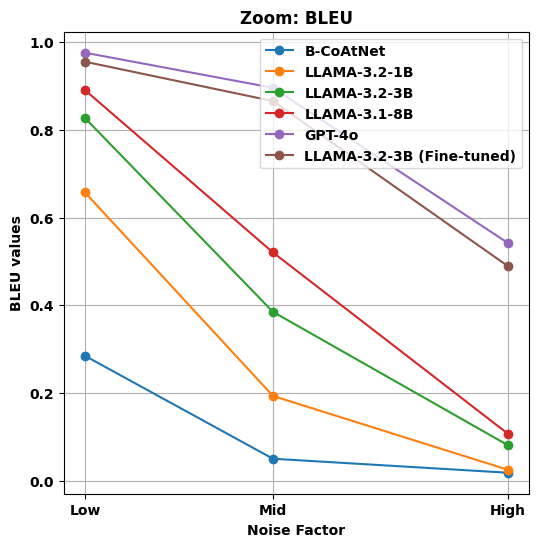

In [18]:
import math 

models = mean_df["Model"].unique()
print(models)
plt.figure(figsize=(6, 6))

for model in models:
    mean_subset = mean_df[mean_df["Model"] == model]
    std_subset = std_df[std_df["Model"] == model]
    
    # Extracting values and ensuring alignment
    x_values = mean_subset["Noise Factor"].values
    y_mean = mean_subset["BLEU Accuracy"].values
    # y_std = std_subset["BLEU Accuracy"].values 
    y_std = 0
    
    # Calculating bounds
    lower_bound = y_mean - y_std
    upper_bound = y_mean + y_std
    
    # Plotting mean line
    plt.plot(x_values, y_mean, marker='o', label=model)
    
    # Adding shaded area
    plt.fill_between(x_values, lower_bound, upper_bound, alpha=0.2)

plt.title("Zoom: BLEU")
plt.xlabel("Noise Factor")
plt.xticks(noise_values, labels=noise_labels)
plt.ylabel("BLEU values")
plt.legend()
plt.grid(True)
plt.savefig("bleu_zoom.pdf")
plt.show()

['B-CoAtNet', 'LLAMA-3.2-1B', 'LLAMA-3.2-3B', 'LLAMA-3.1-8B', 'GPT-4o', 'LLAMA-3.2-3B (Fine-tuned)']
Categories (6, object): ['B-CoAtNet', 'LLAMA-3.2-1B', 'LLAMA-3.2-3B', 'LLAMA-3.1-8B', 'GPT-4o', 'LLAMA-3.2-3B (Fine-tuned)']


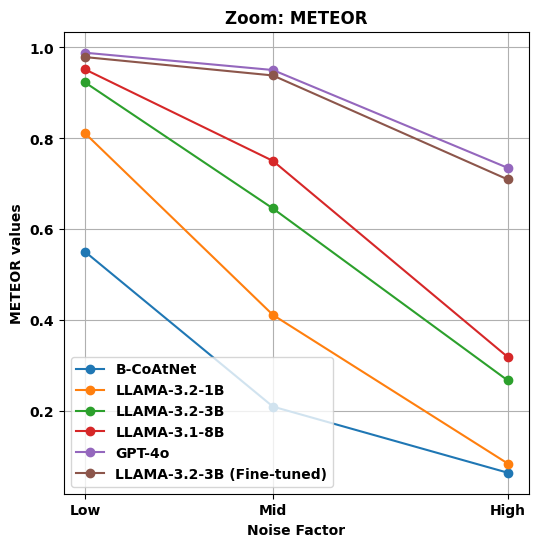

In [19]:
import math 

models = mean_df["Model"].unique()
print(models)
plt.figure(figsize=(6, 6))

for model in models:
    mean_subset = mean_df[mean_df["Model"] == model]
    std_subset = std_df[std_df["Model"] == model]
    
    # Extracting values and ensuring alignment
    x_values = mean_subset["Noise Factor"].values
    y_mean = mean_subset["Meteor Score"].values
    # y_std = std_subset["BLEU Accuracy"].values 
    y_std = 0
    
    # Calculating bounds
    lower_bound = y_mean - y_std
    upper_bound = y_mean + y_std
    
    # Plotting mean line
    plt.plot(x_values, y_mean, marker='o', label=model)
    
    # Adding shaded area
    plt.fill_between(x_values, lower_bound, upper_bound, alpha=0.2)

plt.title("Zoom: METEOR")
plt.xlabel("Noise Factor")
plt.xticks(noise_values, labels=noise_labels)
plt.ylabel("METEOR values")
plt.legend()
plt.grid(True)
plt.savefig("meteor_zoom.pdf")
plt.show()

['B-CoAtNet', 'LLAMA-3.2-1B', 'LLAMA-3.2-3B', 'LLAMA-3.1-8B', 'GPT-4o', 'LLAMA-3.2-3B (Fine-tuned)']
Categories (6, object): ['B-CoAtNet', 'LLAMA-3.2-1B', 'LLAMA-3.2-3B', 'LLAMA-3.1-8B', 'GPT-4o', 'LLAMA-3.2-3B (Fine-tuned)']


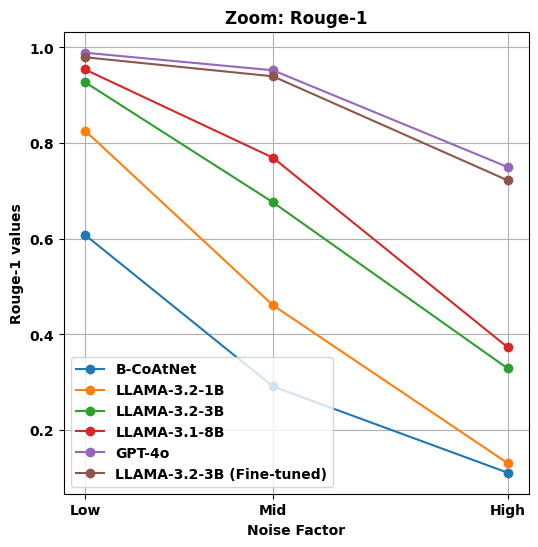

In [20]:
import math 

models = mean_df["Model"].unique()
print(models)
plt.figure(figsize=(6, 6))

for model in models:
    mean_subset = mean_df[mean_df["Model"] == model]
    std_subset = std_df[std_df["Model"] == model]
    
    # Extracting values and ensuring alignment
    x_values = mean_subset["Noise Factor"].values
    y_mean = mean_subset["Rouge-1"].values
    # y_std = std_subset["BLEU Accuracy"].values 
    y_std = 0
    
    # Calculating bounds
    lower_bound = y_mean - y_std
    upper_bound = y_mean + y_std
    
    # Plotting mean line
    plt.plot(x_values, y_mean, marker='o', label=model)
    
    # Adding shaded area
    plt.fill_between(x_values, lower_bound, upper_bound, alpha=0.2)

plt.title("Zoom: Rouge-1")
plt.xlabel("Noise Factor")
plt.xticks(noise_values, labels=noise_labels)
plt.ylabel("Rouge-1 values")
plt.legend()
plt.grid(True)
plt.savefig("rouge1_zoom.pdf")
plt.show()

['B-CoAtNet', 'LLAMA-3.2-1B', 'LLAMA-3.2-3B', 'LLAMA-3.1-8B', 'GPT-4o', 'LLAMA-3.2-3B (Fine-tuned)']
Categories (6, object): ['B-CoAtNet', 'LLAMA-3.2-1B', 'LLAMA-3.2-3B', 'LLAMA-3.1-8B', 'GPT-4o', 'LLAMA-3.2-3B (Fine-tuned)']


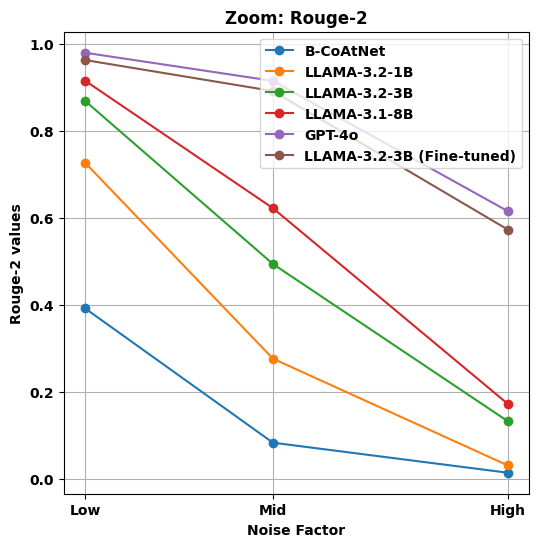

In [21]:
import math 

models = mean_df["Model"].unique()
print(models)
plt.figure(figsize=(6, 6))

for model in models:
    mean_subset = mean_df[mean_df["Model"] == model]
    std_subset = std_df[std_df["Model"] == model]
    
    # Extracting values and ensuring alignment
    x_values = mean_subset["Noise Factor"].values
    y_mean = mean_subset["Rouge-2"].values
    # y_std = std_subset["BLEU Accuracy"].values 
    y_std = 0
    
    # Calculating bounds
    lower_bound = y_mean - y_std
    upper_bound = y_mean + y_std
    
    # Plotting mean line
    plt.plot(x_values, y_mean, marker='o', label=model)
    
    # Adding shaded area
    plt.fill_between(x_values, lower_bound, upper_bound, alpha=0.2)

plt.title("Zoom: Rouge-2")
plt.xlabel("Noise Factor")
plt.xticks(noise_values, labels=noise_labels)
plt.ylabel("Rouge-2 values")
plt.legend()
plt.grid(True)
plt.savefig("rouge2_zoom.pdf")
plt.show()

['B-CoAtNet', 'LLAMA-3.2-1B', 'LLAMA-3.2-3B', 'LLAMA-3.1-8B', 'GPT-4o', 'LLAMA-3.2-3B (Fine-tuned)']
Categories (6, object): ['B-CoAtNet', 'LLAMA-3.2-1B', 'LLAMA-3.2-3B', 'LLAMA-3.1-8B', 'GPT-4o', 'LLAMA-3.2-3B (Fine-tuned)']


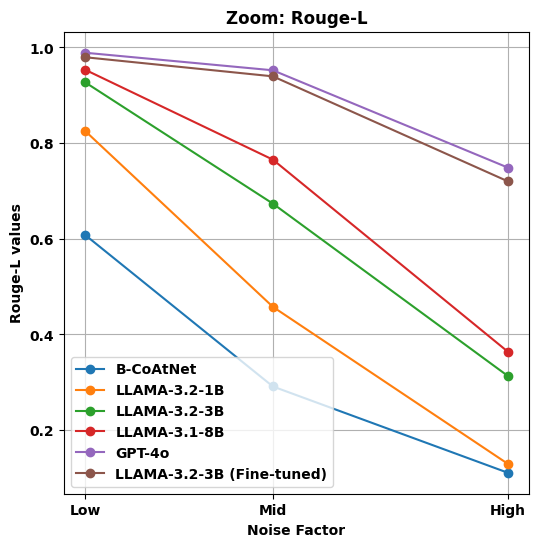

In [22]:
import math 

models = mean_df["Model"].unique()
print(models)
plt.figure(figsize=(6, 6))

for model in models:
    mean_subset = mean_df[mean_df["Model"] == model]
    std_subset = std_df[std_df["Model"] == model]
    
    # Extracting values and ensuring alignment
    x_values = mean_subset["Noise Factor"].values
    y_mean = mean_subset["Rouge-L"].values
    # y_std = std_subset["BLEU Accuracy"].values 
    y_std = 0
    
    # Calculating bounds
    lower_bound = y_mean - y_std
    upper_bound = y_mean + y_std
    
    # Plotting mean line
    plt.plot(x_values, y_mean, marker='o', label=model)
    
    # Adding shaded area
    plt.fill_between(x_values, lower_bound, upper_bound, alpha=0.2)

plt.title("Zoom: Rouge-L")
plt.xlabel("Noise Factor")
plt.xticks(noise_values, labels=noise_labels)
plt.ylabel("Rouge-L values")
plt.legend()
plt.grid(True)
plt.savefig("rougeL_zoom.pdf")
plt.show()